In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("whitegrid")
np.seterr(divide='ignore');

# Combining Newton's method with Bisection

Newton's method features a quadratic convergence rate, but is not guaranteed to converge unless the algorithm is started sufficiently close to the root of a function $f$.  For example, the function

$$ f(x) = \tanh(20x)$$,

where $\tanh$ is the hyperbolic tangent function, has a single root at $x = 0$, but Newton's method will quickly diverge even at modest distances from the root.

Create functions that evaluate this function and it's derivative.  Recall that:

$$\frac{d}{dz}\tanh(z) = 1 - \tanh^2(z)$$

In [2]:
# clear
def f(x):
    return np.tanh(20*x)

def df(x):
    return 20*(1 - f(x)**2)

Plot the function and its derivative over the interval $[-2,2]$.  Use two different plots for the function and its derivative

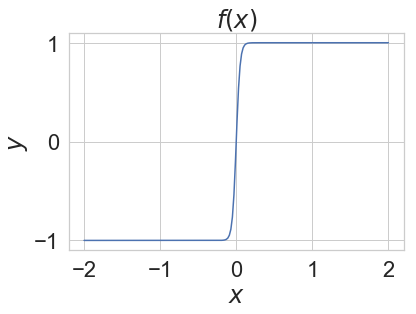

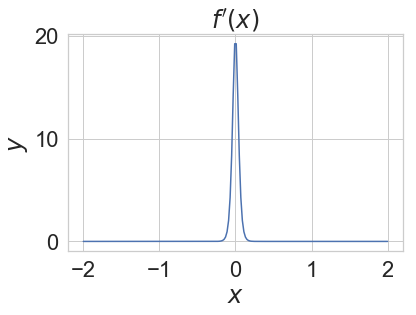

In [3]:
# clear
a0 = -2
b0 = 2

xmesh = np.linspace(a0, b0,200)
plt.plot(xmesh, f(xmesh))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$f(x)$')
plt.show()
plt.plot(xmesh,df(xmesh))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$f\'(x)$')
plt.show()

You should notice that $f'(x) \approx 0$ for most values of the input $x$.  Newton's method, which is given by:

$$ x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}$$

will divide by a very small number unless $x_k \approx 0$.

Even with a starting guess of $x_0 = 0.06$, Newton's method will diverge.

In [4]:
guesses = [0.06]

###### Evaluate the next cell many times in-place (using Ctrl-Enter)
The green dot is the current guess, and the orange line is the corresponding tangent line.  The next iterate will be where the tangent line intersects $x$-axis.

Next iterate will be:  nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


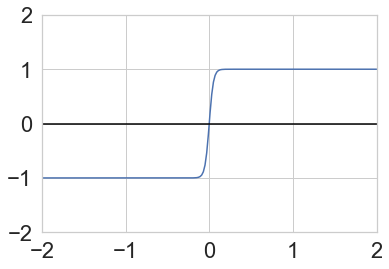

In [9]:
x = guesses[-1] # grab last guess
slope = df(x)

# plot approximate function
plt.plot(xmesh, f(xmesh))
plt.plot(xmesh, f(x) + slope*(xmesh-x))
plt.plot(x, f(x), "o")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.axhline(0, color="black")

# Compute approximate root
xnew = x - f(x) / slope
guesses.append(xnew)

print('Next iterate will be: ', xnew)


On the other hand, the bisection method will always find the root of this function, as long as the initial interval endpoints are of opposite sign.  It will not converge as fast as Newton's method, however.  To get the best of both worlds, we can combine the two as follows.

###### Algorithm
We start with an initial interval $[a,b]$ such that $f(a)\cdot f(b) < 0$ (so that the function values have opposite signs).  We set $c = \text{argmin}_{z=a,b} |f(z)|$, i.e.

$ c = a\hspace{7mm} \text{if  } |f(a)| < |f(b)|$

$ c = b\hspace{7mm} \text{if  } |f(b)| < |f(a)|$

and try to begin a Newton iteration from there (**Question**: why do we select $c$ in this way, why not the reversed inequalities?).  

If the Newton iteration takes us outside the open interval $(a,b)$, then we are not getting any closer to the desired root, and may even be diverging.  In this case, we fall back to the bisection method. 

I.e. we first try:

$m = c - \frac{f(c)}{f'(c)}$

and if $m \geq b$ or $m \leq a$, we scrap this value of $m$ and use the bisection method instead:

$ m = \frac{a + b}{2}$.


Using the same criteria as the standard bisection method, we then update either $a$ or $b$ to have the value $m$.  We then repeat the process and choose the next value of $c = \text{argmin}_{z=a,b} |f(z)|$.  We can terminate whenever $|f(c)| < \text{tol}$.

Write a function that combines the two ideas.  Your function should return the root, as well as a list of tuples that stores $|f(c)|$ and what kind of step was taken:

In [10]:
# clear with hints
def bisection_Newton(a0,b0,tol,f,df):
    steps = []
    a = a0
    b = b0
    fa = f(a)
    fb = f(b)
    if fa*fb > 0:
        print('Root is not bracketed by interval...exiting')
        return None
    if abs(fa) < abs(fb):
        c = a
        fc = fa
    else:
        c = b
        fc = fb
    while abs(fc) > tol:
        m = c - fc/df(c)
        step_type = 'Newton'
        if m < a or m > b: # new value has left interval
            # bisection method
            m = (a + b)/2.
            step_type = 'Bisection'
            
        fm = f(m)
        if fa*fm > 0:
            a = m
            fa = fm
        else:
            b = m
            fb = fm
            
        if abs(fa) < abs(fb):
            c = a
            fc = fa
        else:
            c = b
            fc = fb
        steps.append((abs(fc),step_type))
            
    return c, steps

Test this method on $f(x) = \tanh(20x)$ for the initial interval $[a,b] = [-2,5]$.  Use a tolerance of $10^{-8}$.

In [11]:
a0 = -2
b0 = 5
tol = 1e-8
root, steps = bisection_Newton(a0,b0,tol,f,df)

In [12]:
steps

[(1.0, 'Bisection'),
 (0.9999092042625951, 'Bisection'),
 (0.9999092042625951, 'Bisection'),
 (0.9988944427261528, 'Bisection'),
 (0.5545997223493823, 'Bisection'),
 (0.17416574680846925, 'Newton'),
 (0.003654552196927575, 'Newton'),
 (3.2540049472768056e-08, 'Newton'),
 (2.0679515313825692e-23, 'Newton')]

In [13]:
root

-1.0339757656912846e-24

# GPS Application: N-D Newton's Method
Global Positioning System (GPS) uses 4 satellites to calculate the location of a GPS receiver on earth.  We construct a $xyz$-coordinate system, with the origin located at the center of the Earth.  Relative to this coordinate system, each satellite $i$ has position $(A_i,B_i,C_i)$.  In addition to this, each satellite keeps track of time relative to some reference value, which is denoted $t_i$.

Here we define the values for 4 satellites using the rows of a `numpy`array.  $A_i$, $B_i$ and $C_i$ are measured in kilometers, and $t_i$ is measured in seconds:

In [16]:
Satellites = np.array([[15600, 7540, 20140, 0.07074],
                      [18760, 2750, 18610, 0.07220],
                      [17610, 14630, 13480, 0.07690],
                      [19170, 610, 18390, 0.07242]])

We can plot the satellites in 3D, along with a sphere of radius 6370 km (approximately the radius of the Earth).

In [17]:
# import 3d plotting
from mpl_toolkits.mplot3d import Axes3D

# data for sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# multiply by 6370 km
x = 6370*np.outer(np.cos(u), np.sin(v))
y = 6370*np.outer(np.sin(u), np.sin(v))
z = 6370*np.outer(np.ones(np.size(u)), np.cos(v))

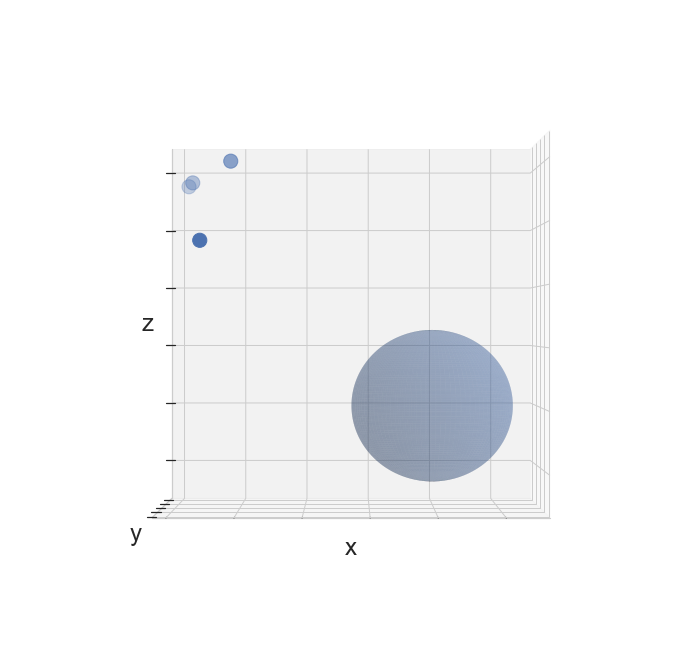

In [18]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(Satellites[:,0],Satellites[:,1], Satellites[:,2],s = 200)
ax.plot_surface(x, y, z, color='b',alpha = 0.3,rstride = 1,cstride = 1,linewidth = 0.0,zorder = 10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.view_init(0,90)
plt.show()

The receiver on Earth has $xyz$ coordinates of it's own, as well as a time delay $d$ that measures the difference between its clock and the reference time.  In order to solve for the location of the receiver and measure it's delay, four nonlinear equations must be solved:

$F_i(\mathbf{X}) = F_i(x,y,z,d) = \sqrt{(x - A_i)^2 + (y - B_i)^2 + (z - C_i)^2} - c(t_i - d),\hspace{7mm} \text{for  } i=1,2,3,4$

Here, $c$ is the speed of light, 299792.456 km/s.  Then we want to solve the nonlinear system of equations

$\mathbf{F}(\mathbf{X}) = \mathbf{0}$,

where $\mathbf{F}(\mathbf{X}) = (F_1(\mathbf{X}),F_2(\mathbf{X}),F_3(\mathbf{X}),F_4(\mathbf{X}))^T$ and $\mathbf{X} = (x,y,z,d)^T$.

### Newton's Method
To solve the equations, we can start with an initial guess $\mathbf{X}_0$ and compute a sequence of approximate solutions by Newton's method:

$\mathbf{J}(\mathbf{X})\mathbf{S}_k = -\mathbf{F}(\mathbf{X})$

$\mathbf{X}_{k+1} = \mathbf{X}_k + \mathbf{S}_k$

$\mathbf{J}(\mathbf{X})$ is the Jacobian of $\mathbf{F}$ evaluated at $\mathbf{X}$ with entries given by $J_{ij} = \frac{\partial F_i}{\partial X_j}$

Write functions that compute both $\mathbf{F}$ and $\mathbf{J}$.

In [20]:
c = 299792.458
# clear
def f(X):
    x,y,z,d = X
    A = Satellites[:,0]
    B = Satellites[:,1]
    C = Satellites[:,2]
    t = Satellites[:,3]
    
    return np.sqrt((x - A)**2 + (y-B)**2 + (z - C)**2) - c*(t - d)

def J(X):
    x,y,z,d = X
    A = Satellites[:,0]
    B = Satellites[:,1]
    C = Satellites[:,2]
    t = Satellites[:,3]
    
    D = np.zeros((4,4))
    denom = np.sqrt((x - A)**2 + (y-B)**2 + (z - C)**2)
    D[:,0] = (x - A)/denom
    D[:,1] = (y - B)/denom
    D[:,2] = (z - C)/denom
    D[:,3] = c
    return D

Let's use an initial guess of a receiver at the South Pole with no time delay: $\mathbf{X}_0 = (0,0,-6370,0)^T$.  Starting from this guess, use Newton's method to locate the receiver on Earth.  Store each updated guess in a list.  You can terminate when $\|\mathbf{F}(\mathbf{X})\|_2 < 10^{-3}$.

In [21]:
X = np.array([0,0,-6370,0])
X_hist = [X]

# clear
for i in range(30):
    A = J(X)
    b = -f(X)
    if np.linalg.norm(b) < 1e-3:
        break
    s = np.linalg.solve(A,b)
    X = X + s
    X_hist.append(X)

You can run this next cell to plot how the guess changed for the first 3 steps:

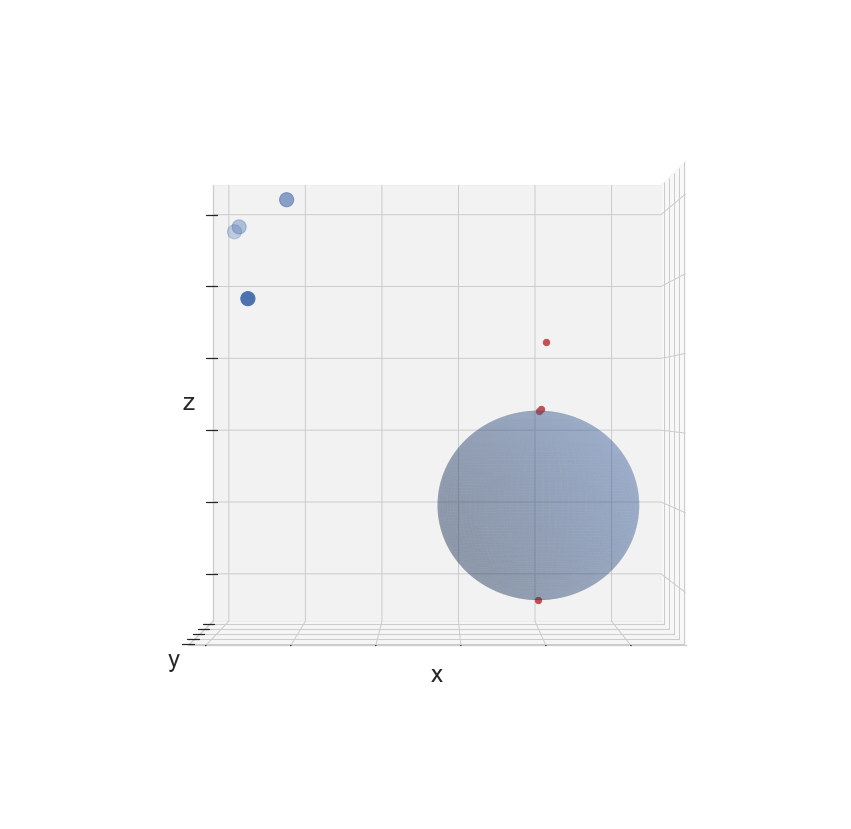

In [22]:
X0 = X_hist[0]
X1 = X_hist[1]
X2 = X_hist[2]
X3 = X_hist[3]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
# Plot the surface
ax.scatter(Satellites[:,0],Satellites[:,1], Satellites[:,2],s = 200)
ax.plot_surface(x, y, z, color='b',alpha = 0.3,rstride = 1,cstride = 1,linewidth = 0.0,zorder = 10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0,90)
ax.scatter(X0[0],X0[1], X0[2],s=40,color='r',alpha = 1,zorder = 0)
ax.scatter(X1[0],X1[1], X1[2],s=40,color='r',alpha = 1,zorder = 0)
ax.scatter(X2[0],X2[1], X2[2],s=40,color='r',alpha = 1,zorder = 0)
ax.scatter(X3[0],X3[1], X3[2],s=40,color='r',alpha = 1,zorder = 0)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
plt.show()

# Secant Method - finding optimal points for numerical integration
*Numerical Quadrature* is a class of methods that attempt to evaluate definite integrals

$\int_a^b f(x) dx$

that are difficult or even impossible to compute by hand.  For example, in optics, the Fresnel integrals

$\int_0^b \cos(x^2)\ dx$

$\int_0^b\sin (x^2)\ dx$

are used to study the diffraction of light.  However, we cannot use anti-derivatives to compute these integrals, because we can't write down a simple formula.

In order to approximate integrals, numerical quadrature replaces them by finite sums:

$\int_a^b f(x)\ dx \approx \sum_{k=1}^N w_k f(x_k)$

where the $w_k$'s are real numbers called *weights* and the $x_k$'s are points in the interval $[a,b]$ with $a\leq x_1 < x_2 < \dots < x_N \leq b$ called *nodes*.

There are many different choices for the weights and nodes, as well as how many of them are used.  For fixed $N$, choosing different points and weights can have a dramatic effect on the accuracy of this method.

### An optimally selected set of points
Gauss-Legendre quadrature uses as nodes the roots of the $N$th-degree *Legendre Polynomials*.  An explicit formula for the $N$-th degree Legendre polynomial is:

$$P_N(x) = \frac{1}{2^n n!} \frac{d^n}{dx^n}(x^2 - 1)^n$$.

I was tempted to ask you to code this up, but that would be kind of annoying.  Luckily `scipy.special` provides a routine `scipy.special.eval_legendre` that computes these functions for you:

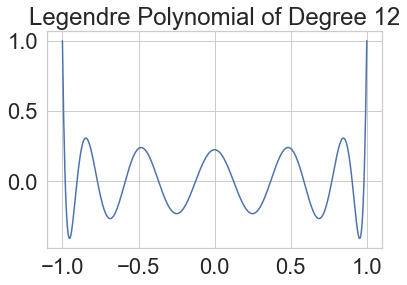

In [45]:
import scipy.special as special
degree = 12
x = np.linspace(-1,1,500)
y = special.eval_legendre(degree,x)
plt.plot(x,y)
plt.title('Legendre Polynomial of Degree 12');

To perform Gauss-Legendre quadrature, we must solve the root-finding problem $P_N(x_k) = 0$ for $k = 1,2,\dots,N$.  We could try Newton's method, but that would require us to compute the derivatives of these polynomials, and `scipy` has no routine for this.

This is fairly common in mathematics and science: often we need to use "special" functions in a variety of applications that have no simple formula.  Rather than sit down and figure out how to code them up, you can usually find a **black box** implementation in a numerical software library.  Black box means you plug in the input, and let the library function do the computation for you without knowing how its implemented.  However, unless the library provides these functions derivatives, you can't do much else besides evaluate them.

##### Find The Roots using the Secant Method
Even though we can't use Newton's method, we can still use the **secant method** since it doesn't require computing any derivatives.  Use the secant method to find the 5 roots of the 5th degree Legendre Polynomial.

In [31]:
# rename the function so you can type less
f = special.eval_legendre

Plot the graph so you can select good initial guesses. You can use the same code snippet from above, just change the degree of the polynomial.

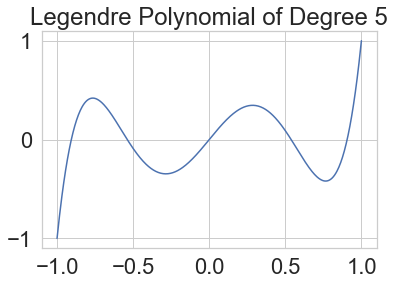

In [47]:
# clear
degree = 5
x = np.linspace(-1,1,500)
y = special.eval_legendre(degree,x)
plt.plot(x,y)
plt.title('Legendre Polynomial of Degree 5');

Recall you need to have two initial guesses.  You might need to experiment.  You also need to pick a good stopping criterion for your method. Make sure to save the optimal solution for each one of the nodes (roots).

In [58]:
# clear 
guesses = [(1,0.9), (0.5, 0.6), (-0.01,0.01), (-0.6, -0.5), (-1, -0.9)]
nodes = np.array([])
MAX_ITER = 100
tol = 1e-8
degree = 5

for i in range(degree):
    x0,x1 = guesses[i]
    print(x0,x1)
    for k in range(MAX_ITER):
        step = -f(degree,x1)*(x1 - x0)/(f(degree,x1) - f(degree,x0))
        x0 = x1
        x1 = x1 + step
        if abs(f(degree,x1)) < tol:
            nodes = np.append(nodes,x1)
            break

1 0.9
0.5 0.6
-0.01 0.01
-0.6 -0.5
-1 -0.9


Verify graphically that the nodes you found are actually roots:

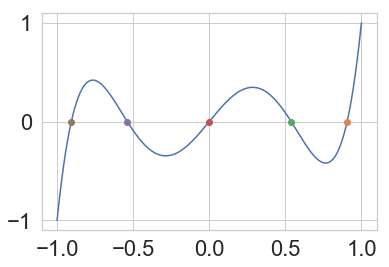

In [59]:
plt.plot(x,y)
plt.plot(nodes[0],f(degree,nodes[0]),'o')
plt.plot(nodes[1],f(degree,nodes[1]),'o')
plt.plot(nodes[2],f(degree,nodes[2]),'o')
plt.plot(nodes[3],f(degree,nodes[3]),'o')
plt.plot(nodes[4],f(degree,nodes[4]),'o')

We can now approximate integrals using the equation:

$\int_{-1}^1 g(x)\ dx \approx \sum_{k=1}^N w_k g(x_k)$

where the $x_k$'s are the nodes you just found.  We'll supply the weights for each node (starting with the left-most node and moving to the right)

In [60]:
weights = np.zeros(5)
weights[0] = weights[-1] = (322 - 13*np.sqrt(70))/900
weights[1] = weights[-2] = (322 + 13*np.sqrt(70))/900
weights[2] = 128/225

Compute the integrals over $[-1,1]$ for the functions $g(x) = \cos\left(\frac{\pi}{2}x\right)$ and $g(x) = x^2 + 1$.  Make sure to sort your nodes correctly.  How close are your answers compared to when you do the integration exactly?

In [61]:
def g(x):
    return np.cos(x)

integral = np.sum(weights*g(np.sort(nodes)))
print(integral)
print(4/np.pi)

1.682941970519036
1.2732395447351628


In [62]:
def g(x):
    return x**2 + 1

integral = np.sum(weights*g(np.sort(nodes)))
print(integral)
print(8/3)

2.6666666664093235
2.6666666666666665
